# Walkability index

## 1.0 Introduction

The walkability index developed by EAFIT University and TEC University will represent the appealingness of street segments of a network in terms of walking by considering both physical and perception variables. The former represent the built environment available for walking along a street segment, while the latter reflect how the population perceives and values the importance of the conditions of that segment. Our study considers six variables (population density, intersection density, land use mix, vegetation, slope, and sidewlaks), each with a physical and perception component. The walkability index is defined as a sum of the multiplication of the perception variables and their corresponding physical variables. Previuos to the calculus of the walkability index, the physical variables needs to be normalized based on the maximum and minimum values across all the analyzed territories, including Medellin and Guadalajara, in order to scale them properly to avoid misinterpretation of the estimations.

## 2.0 Libraries

The Python libraries required for data analysis and visualization are imported.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## 3.0 Reading and storing physical variables

In this step, we load the physical variables that will be used to compute the walkability index. These variables are stored as geospatial data, with each street segment serving as a spatial unit of analysis.

- **Guadalajara:** The data for Guadalajara is already consolidated into a single GeoDataFrame. This file contains all street segments along with the six physical variables required for the index. The data can be read in a single step.

- **Medellín:** For Medellín, the six physical variables are stored in separate files. Each file corresponds to one variable and contains the associated values for each street segment. To prepare the data for further analysis, we will:
    1. Read each variable file into a separate DataFrame.
    2. Merge the six DataFrames based on the street segment identifier.
    3. Create a consolidated GeoDataFrame containing all six variables, ready for normalization and index calculation.

### 3.1 Medellín

In [3]:
TA = ['moravia_LH','floresta_HH','aguacatala_HL']
T = ['medellin', 'guadalajara']
zo = [T[0]] + TA
physical = ['grade_abs','den_pop','den_inter','ind_ndvi','land_use','sidewalk']

edges = []
for z in zo:

    zone_edges = gpd.read_file(f'../data/output/shape/project_network_initial/{z}/{z}_edges_proj_net_initial.shp')
    zone_edges['territorio'] = z 

    # Import physical variables
    slope = gpd.read_file(f'../data/output/shape/physical_variables/slope/{z}/{z}_slope_edges.shp')
    popul = gpd.read_file(f'../data/output/shape/physical_variables/population/{z}/{z}_population_edges.shp')
    inter = gpd.read_file(f'../data/output/shape/physical_variables/intersections/{z}/{z}_intersections_edges.shp')
    veget = gpd.read_file(f'../data/output/shape/physical_variables/vegetation/{z}/{z}_vegetation_edges.shp')
    landu = gpd.read_file(f'../data/output/shape/physical_variables/land_use/{z}/{z}_land_use_edges.shp')
    sidew = gpd.read_file(f'../data/output/shape/physical_variables/sidewalks/{z}/{z}_sidewalks_edges.shp')

    # Filter the geodataframes
    slope = slope[['osmid','grade_abs']]
    popul = popul[['osmid','den_pop']]
    inter = inter[['osmid','den_inter']]
    veget = veget[['osmid','ind_ndvi']]
    landu = landu[['osmid','land_use']]
    sidew = sidew[['osmid','sidewalk']]

    # Combine all the networks
    zone_edges = zone_edges.merge(slope, how='left', on='osmid')
    zone_edges = zone_edges.merge(popul, how='left', on='osmid')
    zone_edges = zone_edges.merge(inter, how='left', on='osmid')
    zone_edges = zone_edges.merge(veget, how='left', on='osmid')
    zone_edges = zone_edges.merge(landu, how='left', on='osmid')
    zone_edges = zone_edges.merge(sidew, how='left', on='osmid')
    zone_edges = zone_edges.fillna(0)

    edges.append(zone_edges)

edges = pd.concat(edges, ignore_index = True)
edges = edges.fillna(0)

#Create a new column for "grade_abs" where the values ​​are "inverted" (1-grade_abs)
edges['grade_abs_'] = edges['grade_abs']
edges['grade_abs'] = 1 - edges['grade_abs_']

### 3.2 Guadalajara

In [4]:
# Import physical variables from Guadalajara
edges_gua = gpd.read_file(f'../data/output/shape/project_network_final/{T[1]}/edges_var_gdl.gpkg')
edges_gua = edges_gua[['u', 'v', 'key', 'grade_abs', 'average_density', 'average_intersdens', 'ndvi_mean', 'entropy', 'banqueta_pct','geometry']]
edges_gua = edges_gua.rename(columns = {'average_density':'den_pop', 'average_intersdens':'den_inter', 'ndvi_mean':'ind_ndvi', 'entropy':'land_use', 'banqueta_pct':'sidewalk'})
edges_gua = edges_gua.fillna(0)

#Create a new column for "grade_abs" where the values ​​are "inverted" (1-grade_abs)
edges_gua['grade_abs_'] = edges_gua['grade_abs']
edges_gua['grade_abs'] = 1 - edges_gua['grade_abs_']

## 4.0 Exploratory data analysis (EDA) from Medellin and Guadalajara

In [5]:
# GeoDataFrame that collects information on the WI calculated from the perception questions
gdf_wi = gpd.GeoDataFrame(columns = ['geometry', 'osmid', 'edge_id', 'territory', 'WI'], crs = 'epsg:32618')
c = 0

# GeoDataFrame that collects information from the WI calculated from the importance questions
gdf_wi_imp = gpd.GeoDataFrame(columns = ['geometry', 'osmid', 'edge_id', 'territory', 'WI_imp'], crs = 'epsg:32618')
c_imp = 0

Before normalizing the physical variables, we first explore the data to identify and handle potential outliers that could distort the scale of the walkability index.

### 4.1 Eliminating Outliers
Outliers can greatly influence the results of normalization. Therefore, it is necessary to detect and remove them prior to applying min-max normalization.

In this step:

1. The Interquartile Range (IQR) method is used to identify outliers in each physical variable.

2. Values falling outside of the range $Q1−1.5\cdot IQR$, $Q3+1.5\cdot IQR$ are considered outliers and will be excluded from the normalization process.

3. To identify these atypical data points, the analysis considers the entire datasets of both Medellín and Guadalajara.

In [6]:
# construction of the box plot considering both the data from Medellin and Guadalajara
box_plot_all = pd.DataFrame()
for z in physical:
    edges_all = pd.concat([edges[edges['territorio'] == T[0]][z], edges_gua[z]], ignore_index = True)
    box_plot_all.loc[z, 'q1'] = edges_all.quantile(q = 0.25)
    box_plot_all.loc[z, 'q2'] = edges_all.quantile(q = 0.50)
    box_plot_all.loc[z, 'q3'] = edges_all.quantile(q = 0.75)
    box_plot_all.loc[z, 'iq'] = box_plot_all.loc[z, 'q3'] - box_plot_all.loc[z, 'q1']
    box_plot_all.loc[z, 'ls'] = box_plot_all.loc[z, 'q3'] + 1.5*box_plot_all.loc[z, 'iq']
    box_plot_all.loc[z, 'li'] = box_plot_all.loc[z, 'q1'] - 1.5*box_plot_all.loc[z, 'iq']
    if box_plot_all.loc[z, 'li'] < 0:
        box_plot_all.loc[z, 'li'] = 0

### 4.2 Normalization

After identifying and excluding outliers (as shown in the previous boxplot analysis), the remaining values of each physical variable are normalized.
Normalization ensures that variables with different units and scales can be meaningfully combined into the walkability index and helps prevent distortions in the interpretation of the results.

The selected method is min-max normalization, which rescales each variable to a 0-1 range:
$$
N_i = \frac{X_i - min(X_i)}{max(X_i) - min(X_i)}
$$
 
Where:

- $N_i$ is the normalized value of physical variable $i$.

- $X_i$ is the raw value of physical variable $i$, after outlier removal.

- $min(X_i)$ and $max(X_i)$ are the lower and upper bounds defined by the boxplot method (i.e., $Q1 - 1.5\cdot IQR$ and $Q3 + 1.5\cdot IQR$), computed across the combined datasets of Medellín and Guadalajara.

**Note:** Using a combined range from both cities ensures that the normalized values remain comparable across different urban contexts, avoiding bias or overestimation in cities with naturally larger or smaller variable distributions.

Once normalized, the variables are ready to be combined with perception data to calculate the walkability index.

In [7]:
# Normalize the physical variables from Medellin
physicalN = [i+'N' for i in physical]
edges_norm_all_MED = edges.copy()
for col in physical:
    edges_norm_all_MED[f'{col}N'] = (edges[col]-box_plot_all.loc[col, 'li'])/(box_plot_all.loc[col, 'ls']-box_plot_all.loc[col, 'li'])
    edges_norm_all_MED[f'{col}N'] = edges_norm_all_MED[f'{col}N'].where(cond = edges_norm_all_MED[f'{col}N'] <= 1, other = 1)
    edges_norm_all_MED[f'{col}N'] = edges_norm_all_MED[f'{col}N'].where(cond = edges_norm_all_MED[f'{col}N'] >= 0, other = 0)
edges_norm_all_MED = edges_norm_all_MED.fillna(0)

# Normalize the physical variables from Guadalajara
edges_norm_all_GUA = edges_gua.copy()
for col in physical:
    edges_norm_all_GUA[f'{col}N'] = (edges_gua[col]-box_plot_all.loc[col, 'li'])/(box_plot_all.loc[col, 'ls']-box_plot_all.loc[col, 'li'])
    edges_norm_all_GUA[f'{col}N'] = edges_norm_all_GUA[f'{col}N'].where(cond = edges_norm_all_GUA[f'{col}N'] <= 1, other = 1)
    edges_norm_all_GUA[f'{col}N'] = edges_norm_all_GUA[f'{col}N'].where(cond = edges_norm_all_GUA[f'{col}N'] >= 0, other = 0)
edges_norm_all_GUA = edges_norm_all_GUA.fillna(0)

## 5.0 Walkability Index form Medellin and Guadalajara

The walkability index is calculated as follows:
$$
WI = \sum_{i = 1}^{n} \beta_i \cdot X_i
$$

Where:
- $WI$ is the walkability index.
- $\beta_i$ are coefficients derived from perception and importance data collected through surveys.
- $X_i$ are the normalized physical indicators.

To perform this calculation, the perception variables are read and the formula is applied accordingly.

It is important to note that for each street segment, two separate walkability indices are computed:

1. One based on the $\beta$ coefficients derived from people's perceptions.

2. Another based on the importance coefficients that people assign to each physical variable.

In the second case (importance-based WI), the slope variable is excluded. This is because, during the survey design, no questions were included to capture the importance that people assign to this particular variable.

In [8]:
# Walkability index for the territories of Medellin
for z in TA:
    zone_nodes = gpd.read_file(f'../data/output/shape/project_network_initial/{z}/{z}_nodes_proj_net_initial.shp')
    zone_edges = edges_norm_all_MED[edges_norm_all_MED['territorio'] == z].reset_index(drop = True)

    # Import perception variables
    name = z.split('_')[0].capitalize()
    perception = pd.read_csv(f'../data/output/table/betas/TA_{name}_betas.txt')
    # Add the suffix 'N' to correctly multiply
    perception['variable'] = perception['variable']+'N'
    perception = perception.set_index('variable')
    # Organice to have the same order as the physical variables
    perception = perception.T[physicalN].T

    # Aquired the Walkability Index
    zone_edges['WI'] = zone_edges[physicalN]@perception

    # Import importance variables
    importance = pd.read_csv(f'../data/output/table/betas/imp_TA_{name}_betas.txt')
    # Add the suffix 'N' to correctly multiply
    importance['variable'] = importance['variable']+'N'
    importance = importance.set_index('variable')
    # Organice to have the same order as the physical variables
    physical_without_slope = physicalN[1:]
    importance = importance.T[physical_without_slope].T

    # Aquired the Walkability Index
    zone_edges['WI_imp'] = zone_edges[physical_without_slope]@importance

    # Limit the study area to the neighborhood polygon
    edges = zone_edges.copy()
    nodes = zone_nodes.copy()

    edges = edges.reset_index()
    edges = edges.to_crs('epsg:32618')
    nodes = nodes.reset_index()
    nodes = nodes.to_crs('epsg:32618')

    if z == 'floresta_HH':
        w = 'Alto_Alta'
    elif z == 'moravia_LH':
        w = 'Bajo_Alta'
    elif z == 'aguacatala_HL':
        w = 'Alto_Baja'

    # Load polygon files
    polygon = gpd.read_file(f'../data/input/shape/Poligonos/{w}.shp')
    polygon = polygon.to_crs('epsg:32618')
    polygon = polygon['geometry'].union_all()
    polygon = gpd.GeoDataFrame(geometry = [polygon], crs = 'epsg:32618')

    # Select the segments that are inside the polygon
    for idx, row in polygon.iterrows():
        # Filter the edges contained in the polygon
        edges_in_polygon = edges[edges['geometry'].intersects(row['geometry'])]

    # List of the nodes inside the polygon based on the 'u' and 'v' columns of the edges inside the polygon
    nodes_in_polygon = edges_in_polygon['u'].to_list() + edges_in_polygon['v'].to_list()
    # Make the nodes unique and sort it
    nodes_in_polygon = list(set(nodes_in_polygon))
    nodes_in_polygon.sort()
    # Select the nodes inside the buffer
    nodes_in_polygon = nodes.set_index('osmid').loc[nodes_in_polygon].reset_index()

    # Save information in GeoDataFrames gdf_wi and gdf_wi_imp
    for index, row in edges_in_polygon.iterrows():
        # WI calculated from the perception questions
        gdf_wi.loc[c, 'geometry'] = row['geometry']
        gdf_wi.loc[c, 'osmid'] = row['osmid']
        gdf_wi.loc[c, 'territory'] = row['territorio']
        gdf_wi.loc[c, 'WI'] = row['WI']
        c = c+1

        # WI calculated from the importance questions
        gdf_wi_imp.loc[c_imp, 'geometry'] = row['geometry']
        gdf_wi_imp.loc[c_imp, 'osmid'] = row['osmid']
        gdf_wi_imp.loc[c_imp, 'territory'] = row['territorio']
        gdf_wi_imp.loc[c_imp, 'WI_imp'] = row['WI_imp']
        c_imp = c_imp+1

In [9]:
# Walkability index for the territories of Guadalajara
TA_GUA = ['miramar_LH', 'providencia_HH', 'colinas_HL']
for x in TA_GUA:
    x_initial = x.split('_')[0]

    # Read nodes and edges of each of the Guadalajara territories
    territory_nodes = gpd.read_file(f'../data/output/shape/project_network_initial/guadalajara_partitions/{x_initial}_nodes_proj_net_rebuilt.gpkg') 
    territory_edges = gpd.read_file(f'../data/output/shape/project_network_initial/guadalajara_partitions/{x_initial}_edges_proj_net_rebuilt.gpkg')

    territory_nodes = territory_nodes.to_crs('epsg:32618')
    territory_edges = territory_edges.to_crs('epsg:32618')

    # Add a common column between the edges of each of the territories of Guadalajara and the GeoDataFrame that contains the physical variables of all of Guadalajara.
    territory_edges['edge_id'] = territory_edges['u'] + territory_edges['v'] + territory_edges['key']
    edges_norm_all_GUA['edge_id'] = edges_norm_all_GUA['u'].astype(str) + edges_norm_all_GUA['v'].astype(str) + edges_norm_all_GUA['key'].astype(str)

    # Merge territory_edges with edges_norm_all_GUA
    territory_edges = territory_edges.merge(edges_norm_all_GUA, on='edge_id')
    territory_edges = territory_edges[['u_x', 'v_x', 'key_x', 'geometry_x', 'edge_id', 'grade_abs', 'den_pop', 'den_inter', 'ind_ndvi', 'land_use', 'sidewalk', 'grade_abs_', 'grade_absN', 'den_popN', 'den_interN', 'ind_ndviN', 'land_useN', 'sidewalkN']]
    territory_edges = territory_edges.rename(columns = {'u_x':'u', 'v_x':'v', 'key_x':'key', 'geometry_x':'geometry'})

    # Calculate the Walkability Index
    # Import perception variables
    name = x.split('_')[0].capitalize()
    perception = pd.read_csv(f'../data/output/table/betas/TA_{name}_betas.txt')
    # Add the suffix 'N' to correctly multiply
    perception['variable'] = perception['variable']+'N'
    perception = perception.set_index('variable')
    # Organice to have the same order as the physical variables
    perception = perception.T[physicalN].T

    # Aquired the Walkability Index
    territory_edges['WI'] = territory_edges[physicalN]@perception

    # Calculate the Walkability Index
    # Import importance variables
    importance = pd.read_csv(f'../data/output/table/betas/imp_TA_{name}_betas.txt')
    # Add the suffix 'N' to correctly multiply
    importance['variable'] = importance['variable']+'N'
    importance = importance.set_index('variable')
    # Organice to have the same order as the physical variables
    importance = importance.T[physical_without_slope].T

    # Aquired the Walkability Index
    territory_edges['WI_imp'] = territory_edges[physical_without_slope]@importance

    # Save information in GeoDataFrames gdf_wi and gdf_wi_imp
    for index, row in territory_edges.iterrows():
        # WI calculated from the perception questions
        gdf_wi.loc[c, 'geometry'] = row['geometry']
        gdf_wi.loc[c, 'edge_id'] = row['edge_id']
        gdf_wi.loc[c, 'territory'] = x
        gdf_wi.loc[c, 'WI'] = row['WI']
        c = c+1

        # WI calculated from the importance questions
        gdf_wi_imp.loc[c_imp, 'geometry'] = row['geometry']
        gdf_wi_imp.loc[c_imp, 'edge_id'] = row['edge_id']
        gdf_wi_imp.loc[c_imp, 'territory'] = x
        gdf_wi_imp.loc[c_imp, 'WI_imp'] = row['WI_imp']
        c_imp = c_imp+1

### 5.1 Normalization of the walkability index

As the final step of the demo, a min-max normalization is applied to the walkability index. This ensures the index can be meaningfully compared across the six territories in both Medellín and Guadalajara.

In [ ]:
# Min-max feature scaling WI
gdf_wi['WIN'] = (gdf_wi['WI']-gdf_wi['WI'].min())/(gdf_wi['WI'].max()-gdf_wi['WI'].min())
gdf_wi = gdf_wi.to_crs('epsg:4326')


gdf_wi_imp['WIN_imp'] = (gdf_wi_imp['WI_imp']-gdf_wi_imp['WI_imp'].min())/(gdf_wi_imp['WI_imp'].max()-gdf_wi_imp['WI_imp'].min())
gdf_wi_imp = gdf_wi_imp.to_crs('epsg:4326')

## 6.0 Results

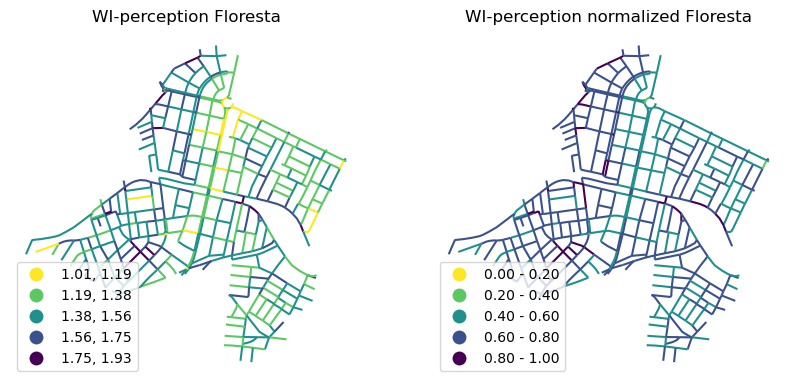

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

ax[0] = gdf_wi[gdf_wi['territory'] == 'floresta_HH'].plot(ax=ax[0], scheme='EqualInterval',
        column='WI',cmap='viridis_r', zorder=1, legend=True, legend_kwds={'loc': 'lower left'})
ax[0].set_title('WI-perception Floresta')
ax[0].axis('off')

bins = [0.20, 0.40, 0.60, 0.80, 1.00]
legend_labels = [
    "0.00 - 0.20",
    "0.20 - 0.40",
    "0.40 - 0.60",
    "0.60 - 0.80",
    "0.80 - 1.00"
    ]
ax[1] = gdf_wi[gdf_wi['territory'] == 'floresta_HH'].plot(
    ax=ax[1],
    scheme='user_defined',
    classification_kwds={'bins': bins},
    column='WIN',
    cmap='viridis_r',
    zorder=1,
    legend=True,
    legend_kwds={'loc': 'lower left', 'labels': legend_labels}
    )
ax[1].set_title('WI-perception normalized Floresta')
ax[1].axis('off')

plt.show()

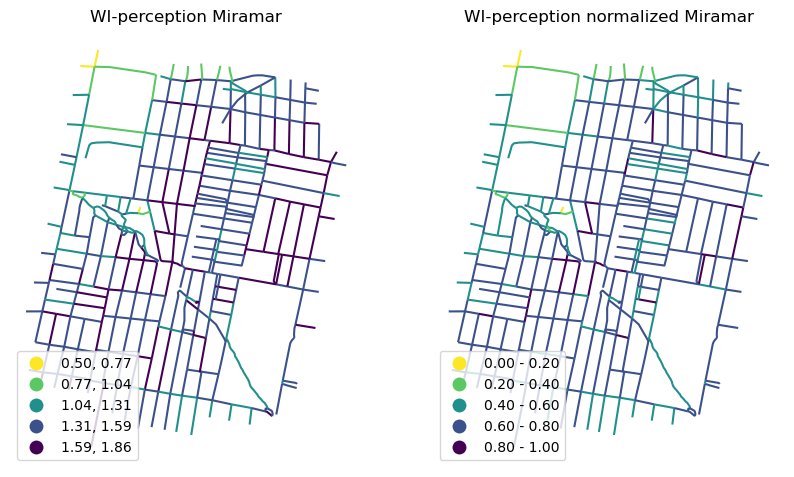

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

ax[0] = gdf_wi[gdf_wi['territory'] == 'miramar_LH'].plot(ax=ax[0], scheme='EqualInterval',
        column='WI',cmap='viridis_r' ,zorder=1, legend=True, legend_kwds={'loc': 'lower left'})
ax[0].set_title('WI-perception Miramar')
ax[0].axis('off')

bins = [0.20, 0.40, 0.60, 0.80, 1.00]
legend_labels = [
    "0.00 - 0.20",
    "0.20 - 0.40",
    "0.40 - 0.60",
    "0.60 - 0.80",
    "0.80 - 1.00"
    ]
ax[1] = gdf_wi[gdf_wi['territory'] == 'miramar_LH'].plot(
    ax=ax[1],
    scheme='user_defined',
    classification_kwds={'bins': bins},
    column='WIN',
    cmap='viridis_r',
    zorder=1,
    legend=True,
    legend_kwds={'loc': 'lower left', 'labels': legend_labels})
ax[1].set_title('WI-perception normalized Miramar')
ax[1].axis('off')

plt.show()